# Twitter API and EDA in Text Mining

## Yiming Tan

This Notebook is about getting data from twitter API and making exploratory data analysis such as the word cloud and topic modelling on the tweets.

In [1]:
#import necesseray library
from urllib.parse import quote
from base64 import b64encode
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords,strip_punctuation, strip_numeric,strip_short

## Authorization Request

Use keys from Twitter's developer platform account to post a authorization request, and get the access token that has to be used when getting tweets in the following steps.

In [2]:
### Twitter's developer platform Key
key = "LNyfQr23p2e1pXPTedQUSbLsG"+":"+"5bDRxVIbk8kkxHakokSqZu1zN3hF9S16JJf7vClhqYRcUCSnUI"
url_encoded_key = quote(key)
###Encoding the key
bearer_b64 = b64encode(bytes(key, 'utf-8')).decode('utf-8')

auth_headers = {
      'Authorization': 'Basic ' + bearer_b64,
      'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8',
      }

#post the authorization request
auth_response = requests.post(url='https://api.twitter.com/oauth2/token',
                                                  headers=auth_headers,
                                                  data={'grant_type': 'client_credentials'})

headers = {
   'Authorization': 'Bearer ' + auth_response.json()['access_token']
}


## Get the tweets

Obtain the html by applying the "get" request and extract information (tweets) from html via BeautifulSoup.

After getting the tweets, put them into a list and store the data in a json file.

Here, we take Trump's tweets as an example.

In [6]:
def get_tweet(user, count, headers, params):
    url = 'https://twitter.com/'+user
    p = {'q':'@noradio','count':count}
    r = requests.get(url, params = params, headers = headers)
    parsed_job_post = BeautifulSoup(r.text, 'html.parser')
    tweet_div = parsed_job_post.find_all(
            'div',
            attrs={'class': ['js-tweet-text-container']})
    # Checks if there's data at all
    tweet_list = []
    for tweet in tweet_div:
        tweet_list.append(tweet.get_text())
    return(tweet_list)

p = {'q':'@noradio','count':100}
tw = get_tweet(user = "realDonaldTrump", count = 100, headers = headers, params = p)
OUTPUT_FILE = OUTPUT_FILE = 'E:/taniesta/Columbia University/Courses Files/Semester II/QMSS-NLP\hw1/{yt2633}_tweeter_DT.json'
json.dump({'request_params': p,
           'tweets': tw},
          open(OUTPUT_FILE, 'w'))

## Word Cloud

Remoce stopwords and generate the word cloud to get a very brief summary on the words.

Democrats, Border, Great, President, people ...

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


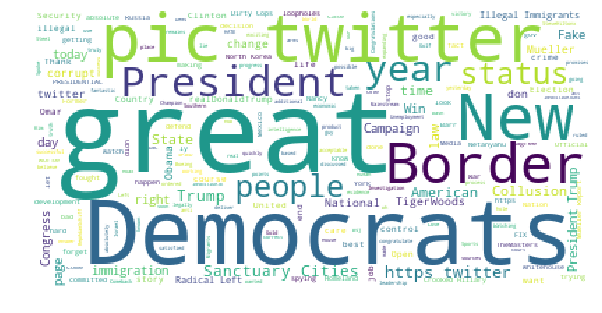

In [18]:
nltk.download('wordnet')
#define a function get_wordcloud to generate a wordcloud given the documents
def get_wordcloud(data):
    Words = [strip_punctuation(strip_numeric(strip_short(remove_stopwords(word)))) for word in data]
    Text = ''.join(Words)
    Text.lower()
    plot = plt.imshow(WordCloud(background_color = "white").generate(Text))
    plt.axis('off')
    plt.rcParams['figure.figsize'] = (10,10)
    plt.show()
    return plot
plot = get_wordcloud(tw)

## Stemming, removing stopwords and tokenizing

In [9]:
stemmer = nltk.SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

processed_docs = list(map(preprocess,tw))

## Topic Modelling with LDA (Latent Dirichlet Allocation)

In [16]:
#prepare corpus
corpus=[preprocess(tag) for tag in tw]
dictionary = gensim.corpora.Dictionary(corpus)
corpus = [dictionary.doc2bow(preprocess(tag)) for tag in tw]

    
dictionary.filter_extremes(no_below=2, no_above=0.99)
corpus = [dictionary.doc2bow(preprocess(tag)) for tag in tw]
    
#lda model
np.random.seed(2019)
lda_model = gensim.models.LdaModel(corpus=corpus, 
                         id2word=dictionary, 
                         random_state=100, 
                         num_topics=5,
                         passes=5,
                         chunksize=10000,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)
lda_model.print_topics(-1)


[(0,
  '0.036*"twitter" + 0.021*"great" + 0.019*"presid" + 0.017*"democrat" + 0.017*"https" + 0.014*"trump" + 0.014*"border" + 0.013*"status" + 0.013*"news" + 0.010*"american"'),
 (1,
  '0.013*"illeg" + 0.013*"immigr" + 0.012*"report" + 0.010*"sanctuari" + 0.009*"citi" + 0.009*"democrat" + 0.008*"good" + 0.008*"elect" + 0.008*"give" + 0.008*"state"'),
 (2,
  '0.011*"great" + 0.011*"mueller" + 0.011*"investig" + 0.009*"build" + 0.009*"north" + 0.009*"know" + 0.009*"collus" + 0.008*"success" + 0.008*"commit" + 0.008*"good"'),
 (3,
  '0.011*"trade" + 0.010*"tri" + 0.010*"unit" + 0.010*"absolut" + 0.009*"trump" + 0.009*"year" + 0.009*"state" + 0.008*"collus" + 0.008*"union" + 0.008*"clinton"'),
 (4,
  '0.016*"immigr" + 0.016*"citi" + 0.014*"sanctuari" + 0.009*"illeg" + 0.009*"law" + 0.009*"care" + 0.009*"possibl" + 0.008*"stori" + 0.008*"case" + 0.008*"want"')]

The result of LDA gives 5 topics, where the number of topics is given by human. In each topic, there are key words that can represent the corresponding topic.

For example, the first one is more related to the campaign and some ideas Trump put forward during the campaign.

The second topic is about illegal immigrations and the third one is Mueller Investigation.